<a href="https://colab.research.google.com/github/liuyao12/Ranger-Mish-ImageWoof-5/blob/master/Woof_128_new_ConvTwist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet with a Twist

> ConvTwist + Mish + MaxBlurPool + restrick

# setup and imports

In [28]:
!pip install git+https://github.com/ayasyrev/model_constructor

  Cloning https://github.com/ayasyrev/model_constructor to /tmp/pip-req-build-f_wz2p1f
  Running command git clone -q https://github.com/ayasyrev/model_constructor /tmp/pip-req-build-f_wz2p1f
  Created wheel for model-constructor: filename=model_constructor-0.1.1-cp36-none-any.whl size=21649 sha256=bd158e0983ce366d22874ddb951d2c9d5d8e21dc6d326fa7fe455b37fcdfa22a
  Stored in directory: /tmp/pip-ephem-wheel-cache-1rk61v9t/wheels/5b/92/65/8093a307d5802f41f4a8776b40bc12b558e75a2a906ae8b683
Successfully built model-constructor


In [3]:
!pip install git+https://github.com/ayasyrev/imagenette_experiments

  Cloning https://github.com/ayasyrev/imagenette_experiments to /tmp/pip-req-build-oi1i8kns
  Running command git clone -q https://github.com/ayasyrev/imagenette_experiments /tmp/pip-req-build-oi1i8kns
     |████████████████████████████████| 143kB 4.4MB/s 
  Created wheel for imagenette-experiments: filename=imagenette_experiments-0.0.1-cp36-none-any.whl size=12379 sha256=e4246a2ea5c51cbfbe0751e48def54f5eff2413e82f9ea4b17354cb59a624b65
  Stored in directory: /tmp/pip-ephem-wheel-cache-plcc8f2l/wheels/af/99/98/2212941f45a18bf6d191f56c39e3569138414560c76defc0d4
Successfully built imagenette-experiments


In [0]:
from imagenette_experiments.train_utils import *

In [0]:
from kornia.contrib import MaxBlurPool2d

In [0]:
from fastai.basic_train import *
from fastai.vision import *
# from fastai.script import *
from model_constructor.net import *
from model_constructor.layers import SimpleSelfAttention, ConvLayer

# Twist

In [0]:
class ConvTwist(nn.Module):  # replacing 3x3 Conv2d
    def __init__(self, ni, nf, stride=1, init=0.7, iters=1):
        super(ConvTwist, self).__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.grad_x = torch.Tensor([[-1,0,1],[-2,0,2],[-1,0,1]])
        self.grad_y = torch.Tensor([[1,2,1],[0,0,0],[-1,-2,-1]])
        std = self.conv.weight.std().item()
        self.coeff_x = nn.Parameter(torch.empty((nf,ni)).normal_(0, std), requires_grad=True)
        self.coeff_y = nn.Parameter(torch.empty((nf,ni)).normal_(0, std), requires_grad=True)
        self.center_x = nn.Parameter(torch.empty((ni,nf)).normal_(0, init), requires_grad=True)
        self.center_y = nn.Parameter(torch.empty((ni,nf)).normal_(0, init), requires_grad=True)
        self.same = ni == nf and stride == 1 and iters > 1
        self.iters = iters
        self.ni = ni

    def forward(self, inpt):
        out = self.conv(inpt)
        _, _, h, w = out.size()
        XX = torch.from_numpy(np.indices((1,1,h,w))[3]*2/w-1).type(out.dtype).to(out.device) 
        YY = torch.from_numpy(np.indices((1,1,h,w))[2]*2/h-1).type(out.dtype).to(out.device)
        kernel_x = self.coeff_x[:,:,None,None] * self.grad_x.to(out.device) + self.coeff_y[:,:,None,None] * self.grad_y.to(out.device) 
        kernel_y = kernel_x.transpose(2,3).flip(3)  # make conv_y a 90 degree rotation of conv_x
        for i in range(self.ni-1):
            out += (XX-self.center_x[i,:,None,None]) * F.conv2d(inpt[:,i:i+1], kernel_x[:,i:i+1], padding=1) + (YY-self.center_y[i,:,None,None]) * F.conv2d(inpt[:,i:i+1], kernel_y[:,i:i+1], padding=1)
        # if self.same:
        #     out = inpt + out / self.iters
        #     for _ in range(self.iters - 1):
        #         out += (self.conv(out) + XX * self.conv_x(out) + YY * self.conv_y(out)) / 3
        #     out -= inpt
        return out

In [129]:
net = ConvTwist(3,5)
# for name, param in net.named_parameters():
#     print(name, param)
print(net.coeff_x.size())

A = torch.Tensor([[-1,0,1],[-2,0,2],[-1,0,1]]) / 2
B = net.coeff_x[:,:,None,None] * A
print(B.size())

torch.Size([3, 5])
torch.Size([3, 5, 3, 3])


# ResBlock

In [0]:
class NewLayer(nn.Sequential):
    """Basic conv layers block"""
    def __init__(self, ni, nf, ks=3, stride=1,
            act=True,  act_fn=nn.ReLU(inplace=True),
            bn_layer=True, bn_1st=True, zero_bn=False,
            padding=None, bias=False, groups=1, **kwargs):

        if padding==None: padding = ks//2
#         layers = [('conv', nn.Conv2d(ni, nf, ks, stride=stride, 
#                 padding=padding, bias=bias, groups=groups))]
        if ks == 1:  layers = [('conv', nn.Conv2d(ni, nf, ks, stride=stride,bias=bias))]
        else:  layers = [('conv_twist', ConvTwist(ni, nf, stride=stride))]

        act_bn = [('act_fn', act_fn)] if act else []
        if bn_layer:
            bn = nn.BatchNorm2d(nf)
            nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
            act_bn += [('bn', bn)]
        if bn_1st: act_bn.reverse()
        layers += act_bn
        super().__init__(OrderedDict(layers))

In [0]:
class NewResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1, 
                 conv_layer=ConvLayer, act_fn=act_fn, bn_1st=True,
                 pool=nn.AvgPool2d(2, ceil_mode=True), sa=False,sym=False, zero_bn=True):
        nf,ni = nh*expansion,ni*expansion
        conv_layer = NewLayer
        self.reduce = noop if stride==1 else pool
        layers  = [(f"conv_0", conv_layer(ni, nh, 3, stride=stride, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1", conv_layer(nh, nf, 3, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ] if expansion == 1 else [
                   (f"conv_0",conv_layer(ni, nh, 1, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1",conv_layer(nh, nh, 3, stride=1, act_fn=act_fn, bn_1st=bn_1st)), #!!!
                   (f"conv_2",conv_layer(nh, nf, 1, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ]
        if sa: layers.append(('sa', SimpleSelfAttention(nf,ks=1,sym=sym)))
        self.convs = nn.Sequential(OrderedDict(layers))
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False, bn_1st=bn_1st)
        self.merge = act_fn

    def forward(self, x): 
        o = self.reduce(x)
        return self.merge(self.convs(o) + self.idconv(o))

In [0]:
# hide
NewResBlock(4, 64, 128)

# Model Constructor

In [0]:
pool = MaxBlurPool2d(3, True)

In [0]:
model = Net(c_out=10, layers=[3,4,6,3], expansion=4)

In [0]:
model.block = NewResBlock
model.pool = pool
model.stem_pool = pool
model.stem_sizes = [3,32,64,64]
model.act_fn= Mish()
model.sa = True

# Params

In [0]:
lr = 0.008
epochs = 5
moms = (0.95,0.95)
start_pct = 0.72
size=128
bs=32
mixup=0.

# Lr find

In [0]:
learn = get_learn(model=model,size=size,bs=bs)

In [0]:
learn.lr_find()

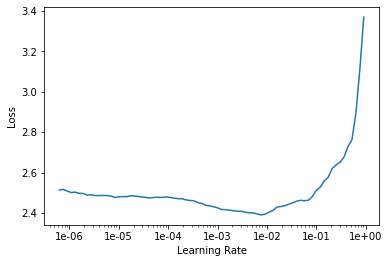

In [0]:
learn.recorder.plot()

# epochs 5 lr 0.008 750-754-749



In [0]:
lr = 4e-3
bs = 16
epochs = 5

In [166]:
learn = get_learn(model=model,size=size,bs=bs,mixup=mixup)
learn.fit_fc(epochs, lr, moms, start_pct)

data path   /root/.fastai/data/imagewoof2


RuntimeError: ignored

In [156]:
for name, param in learn.model.body.named_parameters():
    if 'center' in name:
        print(name, param.size(), param.mean().item(), param.std().item())

l_0.bl_0.convs.conv_1.conv_twist.center_x torch.Size([64, 64]) 0.004544590599834919 0.7047230005264282
l_0.bl_0.convs.conv_1.conv_twist.center_y torch.Size([64, 64]) 0.01089213415980339 0.7095282077789307
l_0.bl_1.convs.conv_1.conv_twist.center_x torch.Size([64, 64]) -0.002963780891150236 0.7049272060394287
l_0.bl_1.convs.conv_1.conv_twist.center_y torch.Size([64, 64]) 0.016438491642475128 0.708461344242096
l_0.bl_2.convs.conv_1.conv_twist.center_x torch.Size([64, 64]) 0.004029544070363045 0.7027405500411987
l_0.bl_2.convs.conv_1.conv_twist.center_y torch.Size([64, 64]) -0.014426160603761673 0.7033509612083435
l_1.bl_0.convs.conv_1.conv_twist.center_x torch.Size([128, 128]) -0.010476648807525635 0.7023114562034607
l_1.bl_0.convs.conv_1.conv_twist.center_y torch.Size([128, 128]) 0.01139790192246437 0.696148693561554
l_1.bl_1.convs.conv_1.conv_twist.center_x torch.Size([128, 128]) 0.007296072319149971 0.6995606422424316
l_1.bl_1.convs.conv_1.conv_twist.center_y torch.Size([128, 128]) -0.

# with iterations and MaxBlurPool

`iters=3`

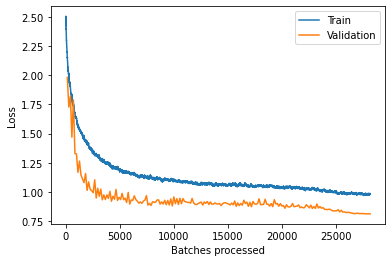

In [24]:
learn.recorder.plot_losses()

In [33]:
for i in range(200):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.36116060614585876
epoch 1 0.43980658054351807
epoch 2 0.4497327506542206
epoch 3 0.579282283782959
epoch 4 0.4749300181865692
epoch 5 0.6558920741081238
epoch 6 0.6446933150291443
epoch 7 0.7213031053543091
epoch 8 0.6869432330131531
epoch 9 0.7340289950370789
epoch 10 0.7449733018875122
epoch 11 0.7627894878387451
epoch 12 0.7141766548156738
epoch 13 0.7900229096412659
epoch 14 0.7579537034034729
epoch 15 0.7907864451408386
epoch 16 0.7818783521652222
epoch 17 0.7981674671173096
epoch 18 0.7538813948631287
epoch 19 0.8164927363395691
epoch 20 0.7930771112442017
epoch 21 0.8091117143630981
epoch 22 0.7892593741416931
epoch 23 0.8248918056488037
epoch 24 0.8129295110702515
epoch 25 0.8243827819824219
epoch 26 0.8058030009269714
epoch 27 0.8213285803794861
epoch 28 0.8004581332206726
epoch 29 0.8220921158790588
epoch 30 0.8147110939025879
epoch 31 0.8266734480857849
epoch 32 0.7984219789505005
epoch 33 0.8282005786895752
epoch 34 0.8213285803794861
epoch 35 0.8292186260223389
e

In [27]:
for name, param in learn.model.body.named_parameters():
    if 'center' in name:
        print(name, param.mean().item(), param.std().item())

l_0.bl_0.convs.conv_1.conv_twist.center_x -0.023459484800696373 0.6863452196121216
l_0.bl_0.convs.conv_1.conv_twist.center_y -0.01983642578125 0.7332205772399902
l_0.bl_1.convs.conv_1.conv_twist.center_x -0.05019049346446991 0.5974913239479065
l_0.bl_1.convs.conv_1.conv_twist.center_y -0.10920649766921997 0.7148696780204773
l_0.bl_2.convs.conv_1.conv_twist.center_x 0.028330177068710327 0.5676637291908264
l_0.bl_2.convs.conv_1.conv_twist.center_y 0.03128380700945854 0.704156756401062
l_1.bl_0.convs.conv_1.conv_twist.center_x -0.06762352585792542 0.6803208589553833
l_1.bl_0.convs.conv_1.conv_twist.center_y -0.05043734610080719 0.5720107555389404
l_1.bl_1.convs.conv_1.conv_twist.center_x -0.04059434309601784 0.5085629820823669
l_1.bl_1.convs.conv_1.conv_twist.center_y -0.06188694015145302 0.6030781865119934
l_1.bl_2.convs.conv_1.conv_twist.center_x -0.02653558924794197 0.5645700097084045
l_1.bl_2.convs.conv_1.conv_twist.center_y -0.05494289845228195 0.6591134071350098
l_1.bl_3.convs.conv_

Plotting the "centers" at the end of training — supposedly these are the points around which the `ConvTwist` is making a tiny rotation or dilation. I don't know what to make of these.

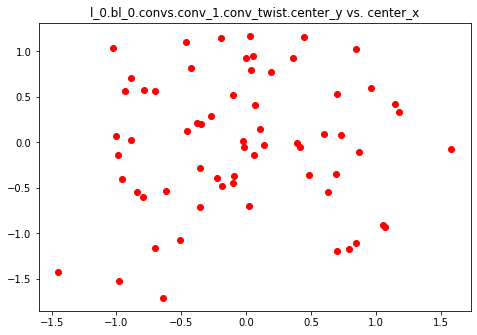

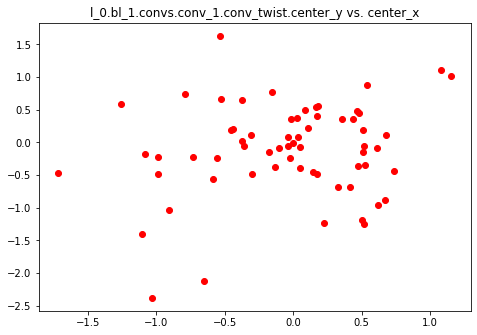

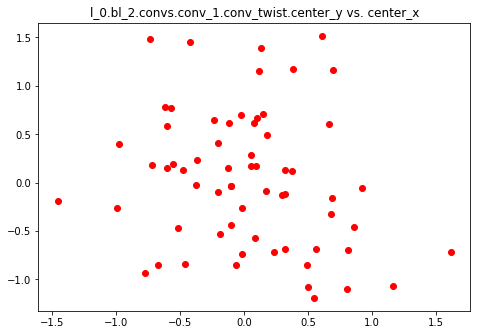

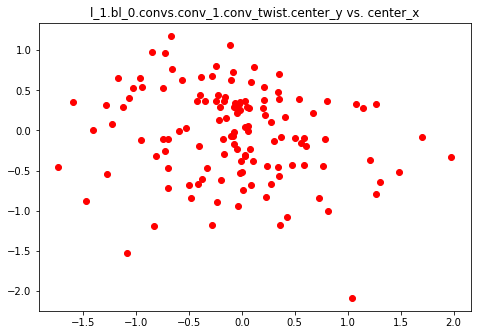

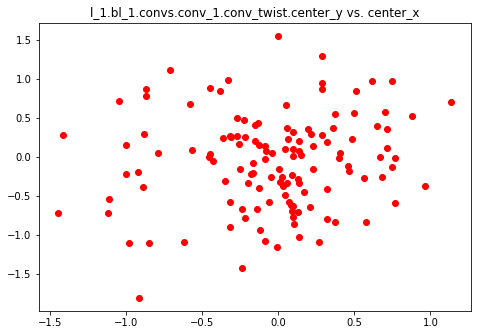

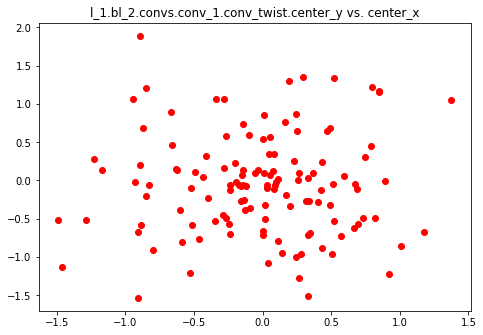

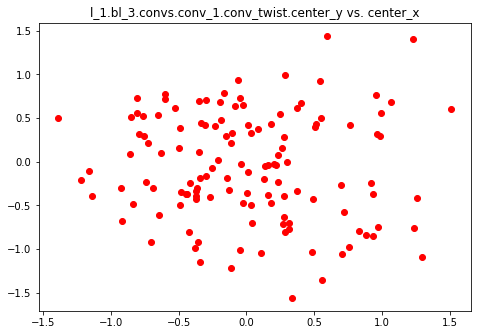

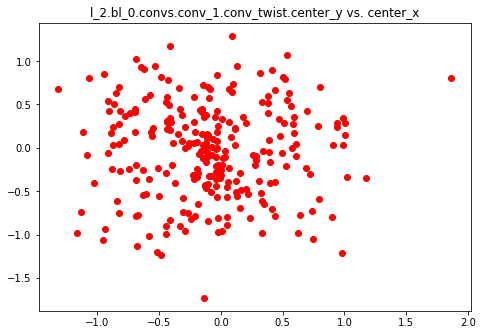

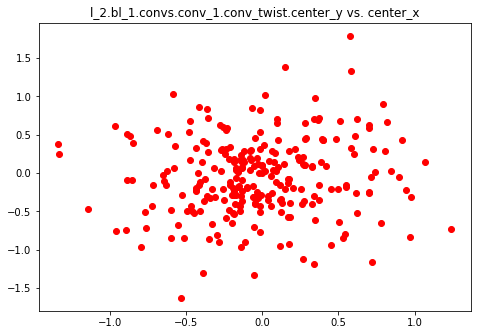

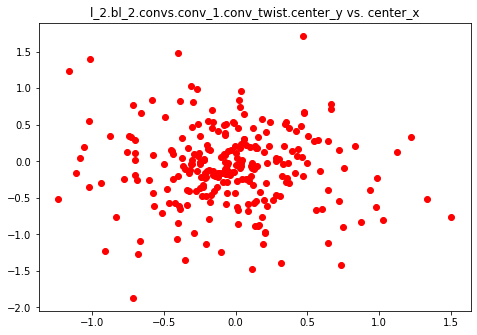

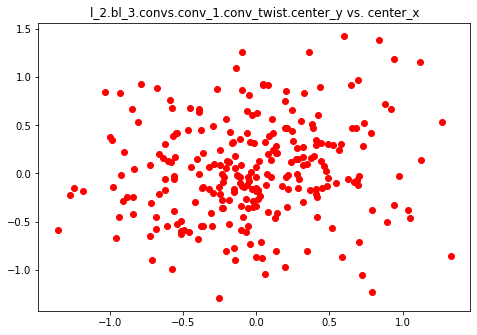

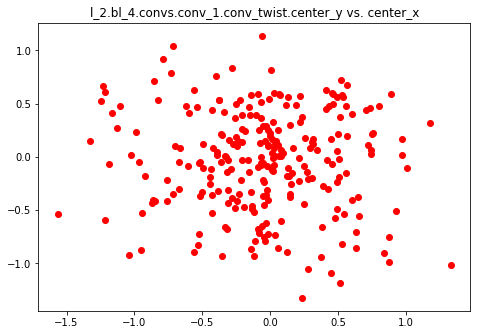

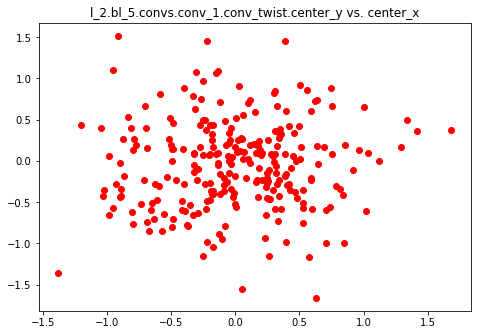

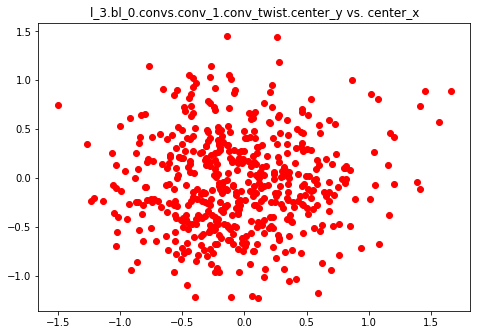

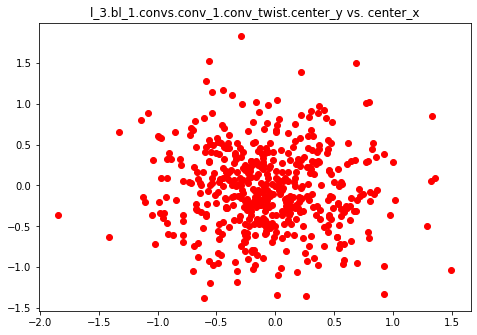

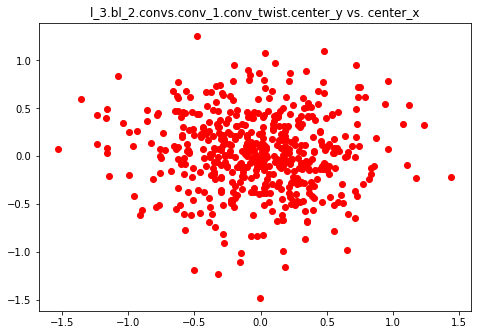

In [28]:
data = [None, None]
for name, param in learn.model.body.named_parameters():
    if 'center_x' in name:
        data[0] = param
    if 'center_y' in name:
        data[1] = param
        center_x = [x.item() for x in data[0]]
        center_y = [y.item() for y in data[1]]
        fig=plt.figure()
        ax=fig.add_axes([0,0,1,1])
        ax.scatter(center_x, center_y, color='r')
        ax.set_title(name + ' vs. center_x')
        plt.show()

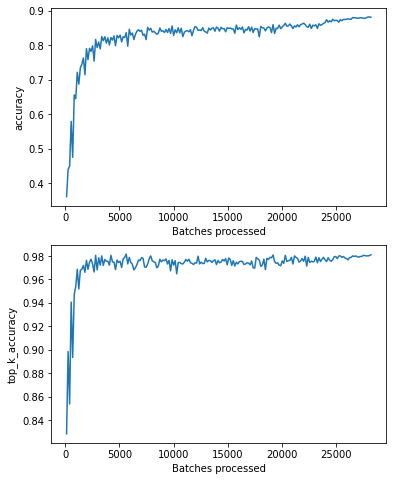

In [29]:
learn.recorder.plot_metrics()

# with iterations but no MaxBlurPool 

`iters=3`

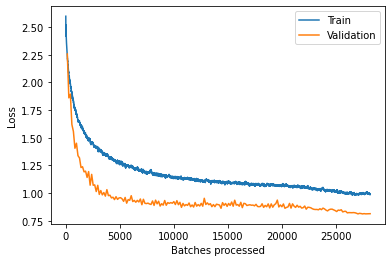

In [38]:
learn.recorder.plot_losses()

In [39]:
for i in range(200):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.2489182949066162
epoch 1 0.37210485339164734
epoch 2 0.3858488202095032
epoch 3 0.5085263252258301
epoch 4 0.5248154997825623
epoch 5 0.6133876442909241
epoch 6 0.5902265310287476
epoch 7 0.6485110521316528
epoch 8 0.6642911434173584
epoch 9 0.6945787668228149
epoch 10 0.6922881007194519
epoch 11 0.7149401903152466
epoch 12 0.7134130597114563
epoch 13 0.7353016138076782
epoch 14 0.7146856784820557
epoch 15 0.7706795334815979
epoch 16 0.7195215225219727
epoch 17 0.770425021648407
epoch 18 0.7709341049194336
epoch 19 0.7935861349105835
epoch 20 0.7729701995849609
epoch 21 0.8058030009269714
epoch 22 0.7938406467437744
epoch 23 0.8124204874038696
epoch 24 0.8058030009269714
epoch 25 0.8065665364265442
epoch 26 0.7900229096412659
epoch 27 0.8086026906967163
epoch 28 0.8040213584899902
epoch 29 0.8121659159660339
epoch 30 0.8172562718391418
epoch 31 0.8251463770866394
epoch 32 0.8170017600059509
epoch 33 0.8231102228164673
epoch 34 0.8218376040458679
epoch 35 0.8185288906097412
ep

In [40]:
for name, param in learn.model.body.named_parameters():
    if 'center' in name:
        print(name, param.mean().item(), param.std().item())

l_0.bl_0.convs.conv_1.conv_twist.center_x -0.009412282146513462 0.724317729473114
l_0.bl_0.convs.conv_1.conv_twist.center_y -0.13338562846183777 0.7636765837669373
l_0.bl_1.convs.conv_1.conv_twist.center_x -0.003539692610502243 0.6031852960586548
l_0.bl_1.convs.conv_1.conv_twist.center_y 0.027359839528799057 0.6279412508010864
l_0.bl_2.convs.conv_1.conv_twist.center_x -0.08917878568172455 0.5440037846565247
l_0.bl_2.convs.conv_1.conv_twist.center_y -0.03030087612569332 0.5485294461250305
l_1.bl_0.convs.conv_1.conv_twist.center_x 0.028511442244052887 0.5888504385948181
l_1.bl_0.convs.conv_1.conv_twist.center_y -0.007085200399160385 0.7024179100990295
l_1.bl_1.convs.conv_1.conv_twist.center_x -0.00041383877396583557 0.617638349533081
l_1.bl_1.convs.conv_1.conv_twist.center_y 0.0271406639367342 0.6702139973640442
l_1.bl_2.convs.conv_1.conv_twist.center_x 0.00874388962984085 0.5452833771705627
l_1.bl_2.convs.conv_1.conv_twist.center_y 0.10775240510702133 0.6405677795410156
l_1.bl_3.convs.c

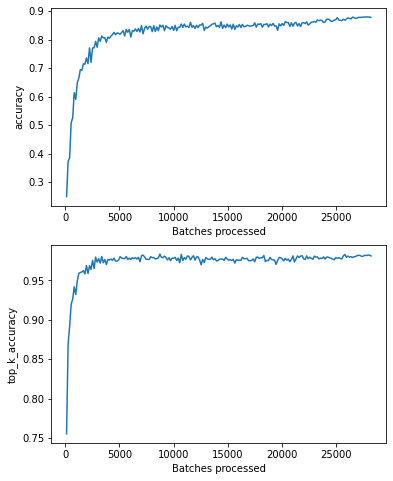

In [41]:
learn.recorder.plot_metrics()